In [ ]:
# For demonstration purposes if need to delete files
import shutil
shutil.rmtree("notMNIST_large")

# Code for Lesson 1 of the Deep Learning Course

### Imports

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import random
import itertools as it
import time
from IPython.display import display, Image, clear_output
from scipy import ndimage
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cross_validation import cross_val_score
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
%matplotlib inline

### Download tar files that contain the images


In [3]:
%%time
url = 'http://commondatastorage.googleapis.com/books1000/'
def download(filename):
  if not os.path.exists(filename):
    print "Dowloading " + filename
    urlretrieve(url + filename, filename)
  else:
    print "File already exists: " + filename
  return filename

train_filename = download('notMNIST_large.tar.gz')
test_fileame = download('notMNIST_small.tar.gz')

File already exists: notMNIST_large.tar.gz
File already exists: notMNIST_small.tar.gz
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.44 ms


### Untar downloaded files

In [4]:
%%time
def untar(filename):
    folder = filename.split(".")[0]
    if os.path.isdir(folder):
        print "%s already extracted" %filename
    else:
        print "Extracting %s, please wait" %filename
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
    extracted_folders = [
        os.path.join(folder, subfolder) for subfolder in sorted(os.listdir(folder))
        if os.path.isdir(os.path.join(folder, subfolder))]
    return extracted_folders
    
train_filename = "notMNIST_large.tar.gz"    
train_folders = untar(train_filename)
test_filename = "notMNIST_small.tar.gz" 
test_folders = untar(test_filename)

Extracting notMNIST_large.tar.gz, please wait
Extracting notMNIST_small.tar.gz, please wait
CPU times: user 54.1 s, sys: 15.7 s, total: 1min 9s
Wall time: 1min 18s


### Visualizing the data

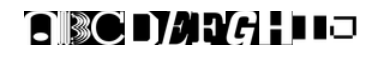

In [8]:
# display a three random image from each letter in the train folder
images = []
for folder in train_folders:
    images_path = os.listdir(folder)
    for i in xrange(1):
        image_path = os.path.join(folder,
                                  random.choice(images_path))
        images.append(plt.imread(image_path))

plt.imshow(np.hstack(images), cmap = 'gray')
plt.axis('off')
plt.show()

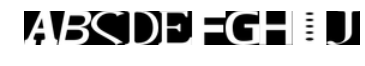

In [9]:
# display a three random imagefrom each letter in the train folder
images = []
for folder in test_folders:
    images_path = os.listdir(folder)
    for i in xrange(1):
        image_path = os.path.join(folder,
                                  random.choice(images_path))
        images.append(plt.imread(image_path))

plt.imshow(np.hstack(images), cmap = 'gray')
plt.axis('off')
plt.show()

In [48]:
%%time
image_size = 28
pixel_depth = 255.0

def load_letter(folder, min_num_images):
    image_paths = os.listdir(folder)
    dataset = np.ndarray(shape = (len(image_paths), image_size,
                                image_size), dtype=np.float32)
    for image_index, image in enumerate(os.listdir(folder)):
        image_path = os.path.join(folder, image)
        try:
#             image_data = ndimage.imread(image_path).astype(float)
            image_data = plt.imread(image_path).astype(float)
            image_data = (image_data - pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception("Unexpected image shape")
            dataset[image_index, :, :] = image_data
        except Exception as e:
            print("Error reading", image_path, ":", e,"- Skipping")
    
    num_images = image_index
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                        (num_images, min_num_images))
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset
    
def pickle_images(data_folders, min_num_images_per_class):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + ".pickle"
        dataset_names.append(set_filename)
        if not os.path.isfile(set_filename):
            print "Getting Images from " + folder
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, "wb") as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print("Unable to save data to", set_filename, ":", e)
        else:
            print "Pickle file already exists" + set_filename
    return dataset_names

train_datasets = pickle_images(train_folders, 45000)
test_datasets = pickle_images(test_folders, 1800)

Pickle file already existsnotMNIST_large/A.pickle
Pickle file already existsnotMNIST_large/B.pickle
Pickle file already existsnotMNIST_large/C.pickle
Pickle file already existsnotMNIST_large/D.pickle
Pickle file already existsnotMNIST_large/E.pickle
Pickle file already existsnotMNIST_large/F.pickle
Pickle file already existsnotMNIST_large/G.pickle
Pickle file already existsnotMNIST_large/H.pickle
Pickle file already existsnotMNIST_large/I.pickle
Pickle file already existsnotMNIST_large/J.pickle
Pickle file already existsnotMNIST_small/A.pickle
Pickle file already existsnotMNIST_small/B.pickle
Pickle file already existsnotMNIST_small/C.pickle
Pickle file already existsnotMNIST_small/D.pickle
Pickle file already existsnotMNIST_small/E.pickle
Pickle file already existsnotMNIST_small/F.pickle
Pickle file already existsnotMNIST_small/G.pickle
Pickle file already existsnotMNIST_small/H.pickle
Pickle file already existsnotMNIST_small/I.pickle
Pickle file already existsnotMNIST_small/J.pickle


### Display Dataset
Let's verify that the data still looks good. Displaying a sample of the letters in the pickle files

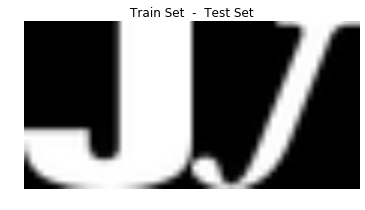

In [34]:
for pickle_file_train, pickle_file_test in zip(train_datasets, test_datasets):
    letter_set_train = pickle.load(open(pickle_file_train, 'rb'))
    letter_set_test = pickle.load(open(pickle_file_test, 'rb'))
    np.random.shuffle(letter_set_train)
    np.random.shuffle(letter_set_test)
    for i in xrange(3):
        clear_output(wait="Ture")
        plt.imshow(np.hstack((letter_set_train[i], letter_set_test[i])), cmap = 'gray')
        plt.title("Train Set  -  Test Set")
        plt.axis('off')
        plt.show()
        time.sleep(0.5)

### Data Balanced
We excpect the data to be balanced across classes

In [38]:
for pickle_file_train, pickle_file_test in zip(train_datasets, test_datasets):
    letter_set_train = pickle.load(open(pickle_file_train, 'rb'))
    print str(pickle_file_train) + ": " + str(len(letter_set_train))
for pickle_file_train, pickle_file_test in zip(train_datasets, test_datasets):
    letter_set_test = pickle.load(open(pickle_file_test, 'rb'))
    print str(pickle_file_test) + ": " + str(len(letter_set_test))

notMNIST_large/A.pickle: 52911
notMNIST_large/B.pickle: 52911
notMNIST_large/C.pickle: 52911
notMNIST_large/D.pickle: 52911
notMNIST_large/E.pickle: 52911
notMNIST_large/F.pickle: 52911
notMNIST_large/G.pickle: 52911
notMNIST_large/H.pickle: 52911
notMNIST_large/I.pickle: 52911
notMNIST_large/J.pickle: 52910
notMNIST_small/A.pickle: 1872
notMNIST_small/B.pickle: 1872
notMNIST_small/C.pickle: 1872
notMNIST_small/D.pickle: 1872
notMNIST_small/E.pickle: 1872
notMNIST_small/F.pickle: 1872
notMNIST_small/G.pickle: 1871
notMNIST_small/H.pickle: 1871
notMNIST_small/I.pickle: 1871
notMNIST_small/J.pickle: 1871


### Make Dataset and Labels
Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [58]:
def make_labels_and_dataset(num_obs, img_size):
    dataset = np.ndarray((num_obs, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(num_obs, dtype=np.int32)
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_labels_and_dataset(valid_size, image_size)
    train_dataset, train_labels = make_labels_and_dataset(train_size, image_size)
    valid_size_per_class = valid_size // num_classes
    train_size_per_class = train_size // num_classes
    
    start_valid, start_train = 0, 0
    end_valid, end_train = valid_size_per_class, train_size_per_class
    end_total = valid_size_per_class + train_size_per_class
    for label, pickle_file in enumerate(pickle_files):
        print "Mergin Images from: " + str(pickle_file)
        letter_set = pickle.load(open(pickle_file, 'rb'))
        #shuffle letters
        np.random.shuffle(letter_set)
        valid_letter = letter_set[:valid_size_per_class, :, :]
        valid_dataset[start_valid:end_valid, :, :] = valid_letter
        valid_labels[start_valid:end_valid] = label
        start_valid += valid_size_per_class
        end_valid += valid_size_per_class
        
        train_letter = letter_set[valid_size_per_class:end_total, :, :]
        train_dataset[start_train:end_train, :, :] = train_letter
        train_labels[start_train:end_train] = label
        start_train += train_size_per_class
        end_train += train_size_per_class
    return valid_labels, valid_dataset, train_labels, train_dataset

train_size = 200000
valid_size = 10000
test_size = 10000

valid_labels, valid_dataset, train_labels, train_dataset = merge_datasets(train_datasets, train_size, valid_size)
_, _, test_labels, test_dataset = merge_datasets(test_datasets, test_size)   

Mergin Images from:notMNIST_large/A.pickle
Mergin Images from:notMNIST_large/B.pickle
Mergin Images from:notMNIST_large/C.pickle
Mergin Images from:notMNIST_large/D.pickle
Mergin Images from:notMNIST_large/E.pickle
Mergin Images from:notMNIST_large/F.pickle
Mergin Images from:notMNIST_large/G.pickle
Mergin Images from:notMNIST_large/H.pickle
Mergin Images from:notMNIST_large/I.pickle
Mergin Images from:notMNIST_large/J.pickle
Mergin Images from:notMNIST_small/A.pickle
Mergin Images from:notMNIST_small/B.pickle
Mergin Images from:notMNIST_small/C.pickle
Mergin Images from:notMNIST_small/D.pickle
Mergin Images from:notMNIST_small/E.pickle
Mergin Images from:notMNIST_small/F.pickle
Mergin Images from:notMNIST_small/G.pickle
Mergin Images from:notMNIST_small/H.pickle
Mergin Images from:notMNIST_small/I.pickle
Mergin Images from:notMNIST_small/J.pickle


In [59]:
print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape) 

('Training:', (200000, 28, 28), (200000,))
('Validation:', (10000, 28, 28), (10000,))
('Testing:', (10000, 28, 28), (10000,))


# Shuffle Data
Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.
Convince yourself that the data is still good after shuffling!


In [73]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

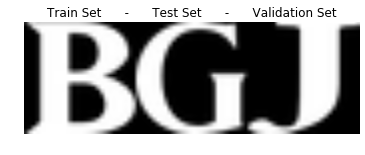

In [74]:
for i in xrange(3):
    clear_output(wait="Ture")
    plt.imshow(np.hstack((train_dataset[i, :, :], test_dataset[i, :, :], valid_dataset[i, :, :])), cmap = 'gray')
    plt.title("Train Set      -      Test Set      -      Validation Set")
    plt.axis('off')
    plt.show()
    time.sleep(0.5)

### Save Data for later in a pickle file

In [75]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [6]:
pickle_file = 'notMNIST.pickle'
statinfo = os.stat(pickle_file)
print "Compresses pickle size: " + str(statinfo.st_size // 1048576) + "MB" 

Compresses pickle size: 658MB


## Overlapping Examples
By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it. Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.

In [66]:
pickle_file = 'notMNIST.pickle'

dic_file = pickle.load(open(pickle_file, 'rb'))
train_dataset = dic_file["train_dataset"]
train_labels = dic_file["train_labels"]
valid_dataset = dic_file["valid_dataset"]
valid_labels = dic_file["valid_labels"]
test_dataset = dic_file["test_dataset"]
test_labels = dic_file["test_labels"]

print "Examples in train dataset: " + str(len(train_labels) / float(1000)) + " thousand"
print "Examples in valid dataset: " + str(len(valid_labels) / float(1000)) + " thousand"
print "Examples in test dataset: " + str(len(test_labels) / float(1000)) + " thousand"

Examples in train dataset: 200.0 thousand
Examples in valid dataset: 10.0 thousand
Examples in test dataset: 10.0 thousand


### Clean Datasets
We will check for repetitions within each datasets first. And remove the duplicates.

In [80]:
def are_equal(img1, img2):
    row = img1.shape[0] / 2
    if np.array_equal(img1[row, :], img2[row, :]):
        return np.array_equal(img1, img2)
    else:
        return False

def find_duplicates(labels1, dataset1, labels2=None, dataset2=None):
    classes = np.unique(labels1)
    duplicate_index = []
    try:
        if not labels2:
            for _class in classes:
                num_duplicates = 0
                index = np.where(labels1 == _class)[0]
                combinations = list(it.combinations(range(len(index)), 2))
                print "Comparisons to make for this class: " + str(len(combinations) / float(1000000)) + " million"
                for i,j in combinations:
                    img1 = dataset1[i]
                    img2 = dataset1[j]
                    if are_equal(img1, img2) == True:
                        duplicate_index.append((i ,j))
                        num_duplicates += 1
                print "The number of matches found in class %d is %d" %(_class, num_duplicates)
            print "Total of matches: %d from a sample size: %d \n\n" %(len(duplicate_index), len(labels1))
    
    except:
        for _class in classes:
            num_duplicates = 0
            index1 = np.where(labels1 == _class)[0]
            index2 = np.where(labels2 == _class)[0]
            print "Comparisons to make for this class: " + \
                  str(len(index1) * len(index1) / float(1000000) / 2) + " million"
            for i in index1:
                for j in index2:
                    if j >= i:
                        img1 = dataset1[i]
                        img2 = dataset2[j]
                        if are_equal(img1, img2) == True:
                            duplicate_index.append((i ,j))
                            num_duplicates += 1
            print "The number of matches found in class %d is %d" %(_class, num_duplicates)
        print "Total of matches: %d from a sample size: %d \n\n" %(len(duplicate_index), len(labels1))
    return duplicate_index
         
duplicate_index_valid = find_duplicates(valid_labels, valid_dataset)
duplicate_index_test = find_duplicates(test_labels, test_dataset)
# duplicate_index_train = find_duplicates(train_labels, train_dataset)

In [15]:
# view duplicated images
def print_images(img1, img2):
    plt.imshow(np.hstack((img1, img2)), cmap = "gray")
    plt.axis("off")
    plt.show()
    
index = random.choice(duplicate_index_test)
print index
print_images(test_dataset[index[0]], test_dataset[index[1]])
# matches seem to correspond to black images!!

IndexError: list index out of range

### Remove Black Images

In [67]:
def remove_solid_color_images(dataset):
    rem_index = []
    for i in xrange(dataset.shape[0]):
        if len(np.unique(dataset[i])) == 1:
            rem_index.append(i)
    return rem_index
    
rem_index_valid = remove_solid_color_images(valid_dataset)
valid_labels = np.delete(valid_labels, rem_index_valid, 0)
valid_dataset = np.delete(valid_dataset, rem_index_valid, 0)

rem_index_test = remove_solid_color_images(test_dataset)
test_labels = np.delete(test_labels, rem_index_test, 0)
test_dataset = np.delete(test_dataset, rem_index_test, 0)

rem_index_train = remove_solid_color_images(train_dataset)
train_labels = np.delete(train_labels, rem_index_train, 0)
train_dataset = np.delete(train_dataset, rem_index_train, 0)

### Rerun duplication

In [48]:
duplicate_index_valid = find_duplicates(valid_labels, valid_dataset)
duplicate_index_test = find_duplicates(test_labels, test_dataset)
# duplicate_index_train = find_duplicates(train_labels, train_dataset)

Comparisons to make for this class: 0.4995 million
The number of matches found in class 0 is 0
Comparisons to make for this class: 0.4995 million
The number of matches found in class 1 is 0
Comparisons to make for this class: 0.4995 million
The number of matches found in class 2 is 0
Comparisons to make for this class: 0.4995 million
The number of matches found in class 3 is 0
Comparisons to make for this class: 0.4995 million
The number of matches found in class 4 is 0
Comparisons to make for this class: 0.4995 million
The number of matches found in class 5 is 0
Comparisons to make for this class: 0.498501 million
The number of matches found in class 6 is 0
Comparisons to make for this class: 0.4995 million
The number of matches found in class 7 is 0
Comparisons to make for this class: 0.399171 million
The number of matches found in class 8 is 0
Comparisons to make for this class: 0.4995 million
The number of matches found in class 9 is 0
Total of matches: 0 from a sample size: 9893 


## Read from Clean Data

In [81]:
pickle_file = 'notMNIST_clean.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

## Start from cleaned datasets

In [82]:
pickle_file = 'notMNIST_clean.pickle'

dic_file = pickle.load(open(pickle_file, 'rb'))
train_dataset = dic_file["train_dataset"]
train_labels = dic_file["train_labels"]
valid_dataset = dic_file["valid_dataset"]
valid_labels = dic_file["valid_labels"]
test_dataset = dic_file["test_dataset"]
test_labels = dic_file["test_labels"]

print "Examples in train dataset: " + str(len(train_labels) / float(1000)) + " thousand"
print "Examples in valid dataset: " + str(len(valid_labels) / float(1000)) + " thousand"
print "Examples in test dataset: " + str(len(test_labels) / float(1000)) + " thousand"

Examples in train dataset: 197.876 thousand
Examples in valid dataset: 9.893 thousand
Examples in test dataset: 9.854 thousand


### Measuring overlap between sets


In [92]:
# print "Duplication Between VALID and TEST"
# duplicate_index1 = find_duplicates(valid_labels, valid_dataset, test_labels, test_dataset)

# print "Duplication Between VALID and TRAIN"
# duplicate_index2 = find_duplicates(valid_labels, valid_dataset, train_labels, train_dataset)

# print "Duplication Between TRAIN and TEST"
# duplicate_index3 = find_duplicates(train_labels, train_dataset, test_labels, test_dataset)

Duplication Between VALID and TRAIN
Comparisons to make for this class: 0.5 million
The number of matches found in class 0 is 79
Comparisons to make for this class: 0.5 million


KeyboardInterrupt: 

(1096, 5445)


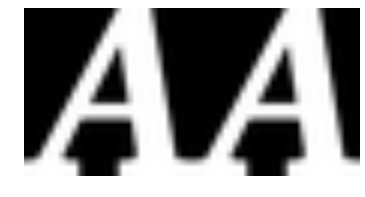

In [91]:
index = random.choice(duplicate_index1)
print index
print_images(valid_dataset[index[0]], test_dataset[index[1]])

# index = random.choice(duplicate_index2)
# print index
# print_images(valid_dataset[index[0]], train_dataset[index[1]])

# index = random.choice(duplicate_index3)
# print index
# print_images(train_dataset[index[0]], test_dataset[index[1]])

### LogisticRegression model
Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.


Train a simple model on this data using 50, 100, 1000 and 5000 training samples. 

Hint: you can use the LogisticRegression model from sklearn.linear_model.
Optional question: train an off-the-shelf model on all the data!


In [93]:
pickle_file = 'notMNIST_clean.pickle'

dic_file = pickle.load(open(pickle_file, 'rb'))
train_dataset = dic_file["train_dataset"]
train_labels = dic_file["train_labels"]
valid_dataset = dic_file["valid_dataset"]
valid_labels = dic_file["valid_labels"]
test_dataset = dic_file["test_dataset"]
test_labels = dic_file["test_labels"]

print "Examples in train dataset: " + str(len(train_labels) / float(1000)) + " thousand"
print "Examples in valid dataset: " + str(len(valid_labels) / float(1000)) + " thousand"
print "Examples in test dataset: " + str(len(test_labels) / float(1000)) + " thousand"

Examples in train dataset: 197.876 thousand
Examples in valid dataset: 9.893 thousand
Examples in test dataset: 9.854 thousand


In [115]:
def train_and_validate(num_examples):
    # flatten datasets
    flat_train = [x.flatten() for x in train_dataset[:num_examples]]
    flat_valid = [x.flatten() for x in valid_dataset[:num_examples]]
    model = LogisticRegressionCV().fit(flat_train, train_labels[:num_examples])
    score = cross_val_score(model, flat_valid, valid_labels[:num_examples]).mean()
    return score

In [121]:
training_sizes = [50, 100, 1000, 5000]
print "Cross Validation Score\n"
for size in training_sizes:
    %time score = train_and_validate(size)
    print "Samples: %d ---> Score: %f" %(size, score)

Cross Validation Score

CPU times: user 7.03 s, sys: 0 ns, total: 7.03 s
Wall time: 7.03 s
Samples: 50 ---> Score: 0.445833
CPU times: user 9.1 s, sys: 0 ns, total: 9.1 s
Wall time: 9.11 s
Samples: 100 ---> Score: 0.587989
CPU times: user 1min 2s, sys: 56 ms, total: 1min 2s
Wall time: 1min 2s
Samples: 1000 ---> Score: 0.781909
